# Getting data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 21)
pd.set_option('display.width', 1000)

In [2]:
"""
# colab data import -1
import datetime
import os
from google.colab import files

merged_df = pd.DataFrame()

folder = "eth_data"
for filename in os.listdir(folder):
    with open(f"{folder}/{filename}", "r") as f:
        raw_date = filename.split("_")[0]
        year = int(raw_date[:4])
        month = int(raw_date[4:6])
        day = int(raw_date[6:8])
        df = pd.read_csv(f, names=["Timestamp", "Open", "High", "Low", "Close", "Volume"])
        df["Datetime"] = pd.to_datetime(datetime.datetime(year, month, day).timestamp() + df['Timestamp'] / 1000, unit="s")
        df.drop("Timestamp", axis=1, inplace=True)
        merged_df = merged_df.append(df)

merged_df.sort_values("Datetime", inplace=True)
merged_df.to_csv("merged/ethereum.csv", index=False)
files.download("merged/ethereum.csv")
""";

In [3]:
"""
# colab data import 1
# This could be automated by connecting it to Google Drive

from google.colab import files
import io

uploaded = files.upload()
""";

In [4]:
"""
# colab data import 2
btc_df = pd.read_csv(io.BytesIO(uploaded['bitcoin.csv']))
eth_df = pd.read_csv(io.BytesIO(uploaded['ethereum.csv']))

dataframes = [btc_df, eth_df]
""";

In [5]:
# local data import
btc_df = pd.read_csv('bitcoin.csv', parse_dates=['Datetime'])
eth_df = pd.read_csv('ethereum.csv', parse_dates=['Datetime'])

dataframes = [btc_df, eth_df]
currencies = ['BTC', 'ETH']
ticker_columns = ['is_btc', 'is_eth']

main_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

In [6]:
# It is not nice that there are these small gaps but its not very bad for now
for df in dataframes:
    print(df['Datetime'].diff().dropna().value_counts().sort_index())

0 days 00:01:00    120902
0 days 00:02:00       317
0 days 00:03:00        18
0 days 00:05:00         2
0 days 00:06:00         3
0 days 00:09:00         1
0 days 00:11:00         1
0 days 00:14:00         1
0 days 00:16:00         1
0 days 00:19:00         1
0 days 00:39:00         1
0 days 02:00:00         1
0 days 09:11:00         1
1 days 00:01:00         1
4 days 00:01:00         1
Name: Datetime, dtype: int64
0 days 00:01:00    118337
0 days 00:02:00      1465
0 days 00:03:00        83
0 days 00:04:00        14
0 days 00:05:00         2
0 days 00:06:00         1
0 days 00:08:00         1
0 days 00:10:00         1
0 days 00:11:00         1
0 days 00:29:00         1
0 days 00:32:00         1
0 days 00:45:00         1
0 days 02:04:00         1
0 days 09:10:00         1
1 days 00:01:00         1
4 days 00:01:00         1
Name: Datetime, dtype: int64


In [7]:
# Take up about half of the space
for df in dataframes:
    for col in main_columns:
        df[col] = df[col].astype('float32')

In [8]:
"""
import plotly.graph_objects as go

candles = 400
def show_candles(candles):
    for df in dataframes:
        fig = go.Figure(data=[go.Candlestick(
                        x=df['Datetime'][:candles],
                        open=df['Open'][:candles],
                        high=df['High'][:candles],
                        low=df['Low'][:candles],
                        close=df['Close'][:candles]
        )])
        fig.update_layout(
            autosize=False,
            width=1000,
            height=300,
            margin=dict(
            l=10, r=10, b=10, t=10, pad=1),
        )
        fig.show()

show_candles(candles)
""";

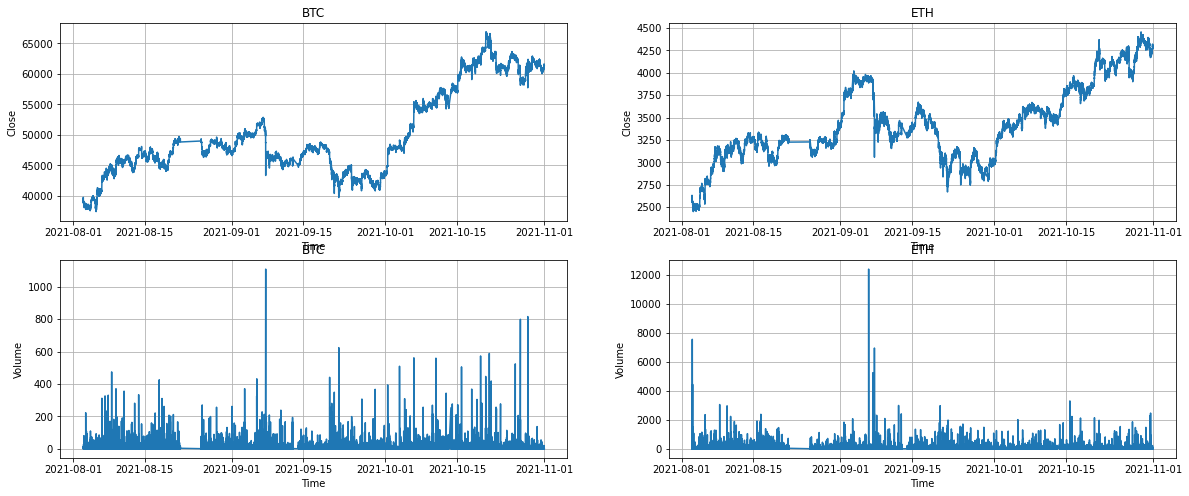

In [9]:
cols = ['Close', 'Volume']
fig, axs = plt.subplots(len(cols), len(dataframes), figsize=(20, 8))

for i in range(len(dataframes)):
    for j in range(len(cols)):
        ax = axs[j][i]
        ax.plot(dataframes[i]['Datetime'], dataframes[i][cols[j]])
        ax.set_xlabel('Time')
        ax.set_ylabel(cols[j])
        ax.set_title(currencies[i])
        ax.grid()
plt.show()

In [10]:
# Other time resolutions - 5 min, 15 min(, 1 hour in QC)
# convert time unit from 1 minute to UNIT minutes
UNIT = 15

for i, df in enumerate(dataframes):
    print(df.shape)
    df['group'] = [int(idx / UNIT) for idx in df.index]
    dataframes[i] = df.groupby('group').aggregate({
        'Open': 'first',
        'High': max,
        'Low': min,
        'Close': 'last',
        'Volume': sum,
        'Datetime': 'first',
    })

for df in dataframes:
    print(df.shape)

(121253, 6)
(119913, 6)
(8084, 6)
(7995, 6)


In [11]:
# ticker one-hot encoding

for i, column in enumerate(ticker_columns):
    for df in dataframes:
        df[column] = 0
    dataframes[i][column] = 1

In [12]:
#show_candles(candles // UNIT)

In [13]:
"""
from statsmodels.graphics.tsaplots import plot_acf

for df in dataframes:
    plot_acf(df['Close'].pct_change().dropna())
    plt.show()
""";

# Feature engineering (that does not leak target variable)

In [14]:
# target - what is the price change in F time units
F = 1
def add_target(df):
    df['target'] = df['Close'].shift(-F) - df['Close']

In [15]:
# rolling close price averages
rolling_periods = [20, 50, 200]
def add_close_rolling_averages(df):
    for period in rolling_periods:
        df[f'close_rolling_average_{period}'] = df['Close'].rolling(period, min_periods=1).mean()

In [16]:
# the heights of parts of the last candle
def add_candle_part_sizes(df):
    df[f'candle_height'] = df['Close'] - df['Open']
    df[f'top_wick_height'] = df['High'] - df[['Open', 'Close']].max(axis=1)
    df[f'bottom_wick_height'] = df[['Open', 'Close']].min(axis=1) - df['Low']

In [17]:
# rolling min low and max high
def add_rolling_price_extremes(df):
    for period in rolling_periods:
        df[f'price_rolling_min_{period}'] = df['Low'].rolling(period, min_periods=1).min()
        df[f'price_rolling_max_{period}'] = df['High'].rolling(period, min_periods=1).max()

In [18]:
# rolling min low and max high
def add_rolling_price_volatilities(df):
    for period in rolling_periods:
        # take into account lows and highs instead?
        df[f'price_rolling_volatility_{period}'] = df['Close'].rolling(period, min_periods=1).std()

In [19]:
# time features
def add_time_features(df):
    df[f'hour'] = df['Datetime'].dt.hour
    df[f'weekday'] = df['Datetime'].dt.dayofweek

In [20]:
for df in dataframes:
    add_target(df)
    add_close_rolling_averages(df)
    add_candle_part_sizes(df)
    add_rolling_price_extremes(df)
    add_rolling_price_volatilities(df)
    add_time_features(df)

In [21]:
# instead of absolute prices we use percent change for original columns and proportion of close for new features
# also let's represent all percentages as percentages (34%), not fractions (0.34), 
# so that numbers don't get so small that its uncomfortable to look at them
close_scale_columns = (['target'] + 
                       [f'close_rolling_average_{period}' for period in rolling_periods] + 
                       [f'price_rolling_min_{period}' for period in rolling_periods] + 
                       [f'price_rolling_max_{period}' for period in rolling_periods] + 
                       [f'price_rolling_volatility_{period}' for period in rolling_periods] + 
                       ['candle_height', 'top_wick_height', 'bottom_wick_height'] + 
                       ['hour', 'weekday'])

for df in dataframes:
    for column in close_scale_columns:
        df[column] = df[column] / df['Close'] * 100

In [22]:
# Separate datasets for RNNs and all other models
rnn_dataframes = [df.copy() for df in dataframes]
other_dataframes = [df.copy() for df in dataframes]
del dataframes

tree_features = [
    ('Open', 20),
    ('High', 20),
    ('Low', 20),
    ('Close', 20),
    ('Volume', 20)
]

for df in other_dataframes:
    for column, n in tree_features:
        change = df[column].pct_change() * 100
        for i in range(n):
            df[f'{column}_change_lag_{i}'] = change.shift(i)
        df.drop([column], axis=1, inplace=True)

for df in rnn_dataframes:
    for column in main_columns:
        df_column = df[column].pct_change() * 100

# Join currencies and split data into train/validation/test

In [23]:
# we can freely .dropna() since very few columns will be lost
for dataframes in [rnn_dataframes, other_dataframes]:
    for df in dataframes:
        print(df.isna().any(axis=1).sum())

2
2
21
21


In [24]:
rnn_all_df = pd.concat(rnn_dataframes, ignore_index=True)
rnn_all_df.dropna(inplace=True)
rnn_all_df.sort_values(by=['Datetime']+ticker_columns, inplace=True)
rnn_all_df.reset_index(drop=True, inplace=True)
rnn_all_df.drop('Datetime', axis=1, inplace=True)
del rnn_dataframes

other_all_df = pd.concat(other_dataframes, ignore_index=True)
other_all_df.dropna(inplace=True)
other_all_df.sort_values(by=['Datetime']+ticker_columns, inplace=True)
other_all_df.reset_index(drop=True, inplace=True)
other_all_df.drop('Datetime', axis=1, inplace=True)
del other_dataframes

In [25]:
# train 0.7, validation 0.15, test 0.15

rnn_validation_start = int(len(rnn_all_df) * 0.7)
rnn_test_start = int(len(rnn_all_df) * 0.85)

rnn_train = rnn_all_df[:rnn_validation_start]
rnn_validation = rnn_all_df[rnn_validation_start:rnn_test_start]
rnn_test = rnn_all_df[rnn_test_start:]
del rnn_all_df


other_validation_start = int(len(other_all_df) * 0.7)
other_test_start = int(len(other_all_df) * 0.85)

other_train = other_all_df[:other_validation_start]
other_validation = other_all_df[other_validation_start:other_test_start]
other_test = other_all_df[other_test_start:]
del other_all_df

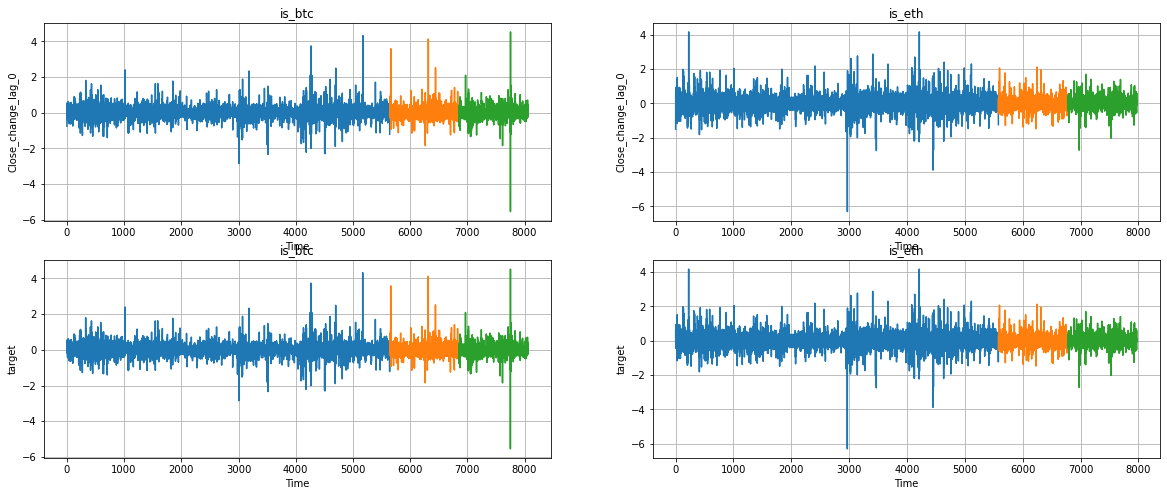

In [26]:
cols = ['Close_change_lag_0', 'target']
fig, axs = plt.subplots(len(cols), len(ticker_columns), figsize=(20, 8))

for i, ticker_column in enumerate(ticker_columns):
    for j in range(len(cols)):
        ax = axs[j][i]
        
        cum_start = 0
        for df in [other_train, other_validation, other_test]:
            df_ = df[df[ticker_column] == 1]
            ax.plot(range(cum_start, cum_start + len(df_)), df_[cols[j]])
            cum_start += len(df_)

        ax.set_xlabel('Time')
        ax.set_ylabel(cols[j])
        ax.set_title(ticker_column)
        ax.grid()
plt.show()

# Feature engineering (that does leak target variable)
(PCA and anything else with a .fit() method, mean encodings, etc.)

[0.06162431 0.05833461 0.05797499 0.0573781 ]


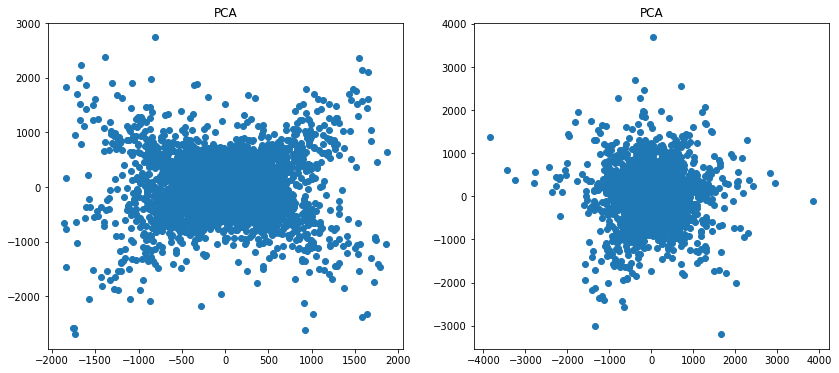

CPU times: user 2.17 s, sys: 834 ms, total: 3 s
Wall time: 1.09 s


In [27]:
%%time
# PCA, for now only for other_x, not really useful
from sklearn.decomposition import PCA

pca = PCA(n_components=4)

train_pca = pca.fit_transform(other_train.drop(['target'], axis=1)).T
validation_pca = pca.transform(other_validation.drop(['target'], axis=1)).T
test_pca = pca.transform(other_test.drop(['target'], axis=1)).T

print(pca.explained_variance_ratio_)

for i in range(pca.n_components_):
    other_train[f'PCA_{i}'] = train_pca[i]
    other_validation[f'PCA_{i}'] = validation_pca[i]
    other_test[f'PCA_{i}'] = test_pca[i]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for i, (a, b) in enumerate([(0, 1), (2, 3)]):
    ax = axs[i]
    ax.scatter(train_pca[a], train_pca[b])
    ax.set_title('PCA')

plt.show()

In [28]:
# normalize all columns except target for rnns

normalized = (rnn_train - rnn_train.mean()) / rnn_train.std()
normalized['target'] = rnn_train['target']
rnn_train = normalized

normalized = (rnn_validation - rnn_validation.mean()) / rnn_validation.std()
normalized['target'] = rnn_validation['target']
rnn_validation = normalized

normalized = (rnn_test - rnn_test.mean()) / rnn_test.std()
normalized['target'] = rnn_test['target']
rnn_test = normalized
del normalized

# Save data for training

In [29]:
%%time
pickle.dump(other_train, open('other_train.pickle', 'wb'))
pickle.dump(other_validation, open('other_validation.pickle', 'wb'))
pickle.dump(other_test, open('other_test.pickle', 'wb'))
del other_train, other_validation, other_test

CPU times: user 23.4 ms, sys: 6.78 ms, total: 30.2 ms
Wall time: 28.9 ms


In [30]:
%%time
rnn_sequence_length = 50

rnn_train_X, rnn_train_y = [], []
rnn_validation_X, rnn_validation_y = [], []
rnn_test_X, rnn_test_y = [], []

for ticker_column in ticker_columns:
    for dataset, dataset_X, dataset_y in [(rnn_train, rnn_train_X, rnn_train_y), 
                                          (rnn_validation, rnn_validation_X, rnn_validation_y), 
                                          (rnn_test, rnn_test_X, rnn_test_y)]:
        dataset_data_subset = dataset[dataset[ticker_column] > 0].copy()

        dataset_y.extend(dataset_data_subset['target'].values[rnn_sequence_length:])
        dataset_data_subset.drop('target', axis=1, inplace=True)

        for i in range(rnn_sequence_length, len(dataset_data_subset)):
            dataset_X.append(dataset_data_subset[i-rnn_sequence_length:i].values)

del rnn_train, rnn_validation, rnn_test

rnn_train_X, rnn_train_y = np.array(rnn_train_X), np.array(rnn_train_y)
rnn_validation_X, rnn_validation_y = np.array(rnn_validation_X), np.array(rnn_validation_y)
rnn_test_X, rnn_test_y = np.array(rnn_test_X), np.array(rnn_test_y)

CPU times: user 680 ms, sys: 47.7 ms, total: 728 ms
Wall time: 726 ms


In [31]:
%%time
pickle.dump(rnn_train_X, open('rnn_train_X.pickle', 'wb'))
pickle.dump(rnn_train_y, open('rnn_train_y.pickle', 'wb'))
pickle.dump(rnn_validation_X, open('rnn_validation_X.pickle', 'wb'))
pickle.dump(rnn_validation_y, open('rnn_validation_y.pickle', 'wb'))
pickle.dump(rnn_test_X, open('rnn_test_X.pickle', 'wb'))
pickle.dump(rnn_test_y, open('rnn_test_y.pickle', 'wb'))
del rnn_train_X, rnn_train_y, rnn_validation_X, rnn_validation_y, rnn_test_X, rnn_test_y

CPU times: user 46.6 ms, sys: 273 ms, total: 320 ms
Wall time: 770 ms


# Benchmarks basis

In [32]:
other_train = pickle.load(open('other_train.pickle', 'rb'))
other_validation = pickle.load(open('other_validation.pickle', 'rb'))
other_test = pickle.load(open('other_test.pickle', 'rb'))

other_train_X = other_train.drop(['target'], axis=1)
other_train_y = other_train['target']
other_validation_X = other_validation.drop(['target'], axis=1)
other_validation_y = other_validation['target']
other_test_X = other_test.drop(['target'], axis=1)
other_test_y = other_test['target']

del other_train, other_validation, other_test
other_train_X.shape

(11225, 123)

In [33]:
# What is the distribution of price change percentages?
# This helps decide how big a change prediction is suitable for buying or selling and gives context to RMSE
def print_quantiles(series):
    quantiles = np.array([x * 0.05 for x in range(21)])
    print(pd.DataFrame({
        'top_quantile': 1-quantiles,
        'change': np.nanquantile(series, quantiles),
        'abs_change': np.nanquantile(np.abs(series), quantiles)
    }).sort_values('top_quantile').reset_index(drop=True))

print_quantiles(other_train_y)

    top_quantile    change  abs_change
0           0.00  4.321986    6.305454
1           0.05  0.608091    0.831779
2           0.10  0.429131    0.606762
3           0.15  0.334944    0.494907
4           0.20  0.262213    0.426192
5           0.25  0.204780    0.374744
6           0.30  0.159631    0.328569
7           0.35  0.117681    0.290799
8           0.40  0.079936    0.257012
9           0.45  0.040907    0.227571
10          0.50  0.005419    0.201323
11          0.55 -0.030143    0.176390
12          0.60 -0.066756    0.154936
13          0.65 -0.105895    0.132712
14          0.70 -0.148384    0.111326
15          0.75 -0.196993    0.092279
16          0.80 -0.252551    0.073223
17          0.85 -0.322273    0.053696
18          0.90 -0.422606    0.035634
19          0.95 -0.604812    0.018095
20          1.00 -6.305454    0.000000


In [34]:
# train mean target prediction benchmark
from sklearn.metrics import mean_squared_error

train_mean_target = other_train_y.mean()
print('Mean % change:')
print(train_mean_target)
print('Mean absolute % change:')
print(other_train_y.abs().mean())

train_mean_prediction = [train_mean_target] * len(other_train_y)
validation_mean_prediction = [train_mean_target] * len(other_validation_y)
test_mean_prediction = [train_mean_target] * len(other_test_y)
print('Constant mean RMSE on 3 splits:')
print(mean_squared_error(train_mean_prediction, other_train_y, squared=False))
print(mean_squared_error(validation_mean_prediction, other_validation_y, squared=False))
print(mean_squared_error(test_mean_prediction, other_test_y, squared=False))

Mean % change:
0.006291769444942474
Mean absolute % change:
0.2858472168445587
Constant mean RMSE on 3 splits:
0.42353772919420785
0.3624353551791834
0.3779406426074183


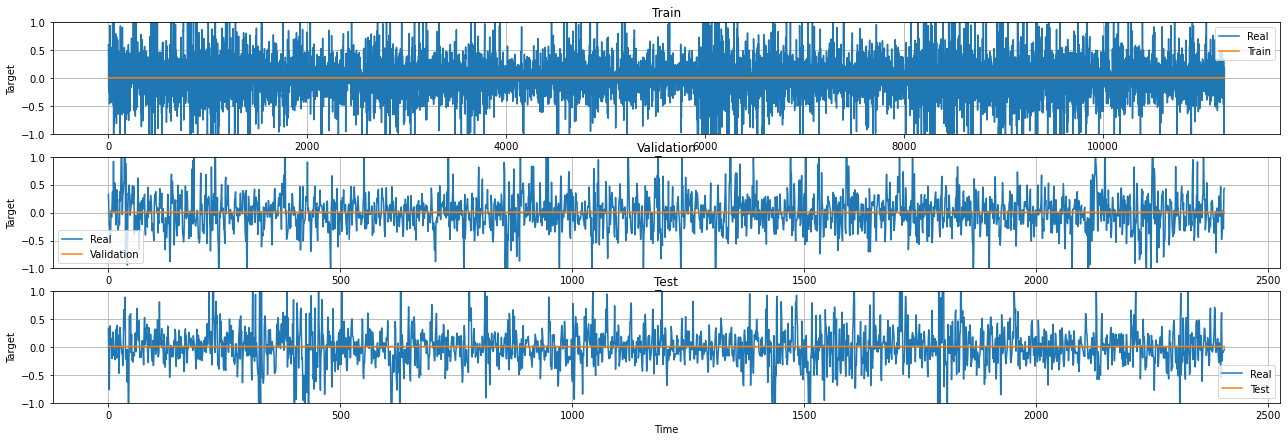

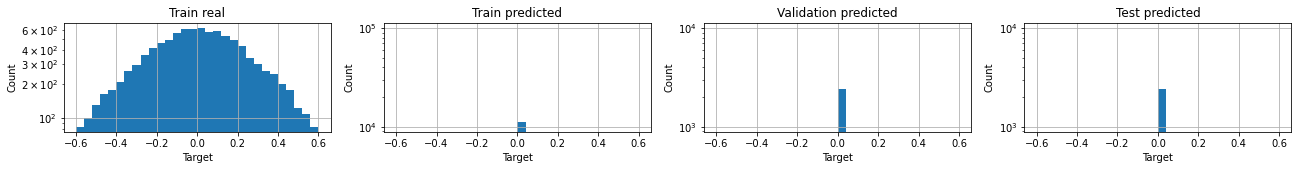

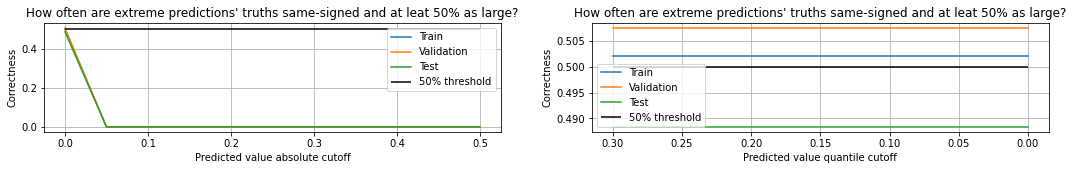

In [35]:
# Add some correlation as well?
def visualize_model_predictions(real_train, real_validation, real_test, predicted_train, predicted_validation, predicted_test):

    # 3 graphs of target and predicted target, all below eachother
    fig, axs = plt.subplots(3, 1, figsize=(22, 7))

    for i, real, predicted, name in [(0, real_train, predicted_train, 'Train'),
                                     (1, real_validation, predicted_validation, 'Validation'),
                                     (2, real_test, predicted_test, 'Test')]:
        ax = axs[i]
        x = list(range(len(real)))
        ax.plot(x, real, label='Real')
        ax.plot(x, predicted, label=name)

        ax.set_xlabel('Time')
        ax.set_ylabel('Target')
        ax.set_title(name)

        ax.set_ylim(-1.0, 1.0)
        ax.legend()
        ax.grid()

    plt.show()
    
    # histograms of target values in train and predicted 3 splits, all next to eachother
    fig, axs = plt.subplots(1, 4, figsize=(22, 2))

    for i, targets, name in [(0, real_train, 'Train real'),
                             (1, predicted_train, 'Train predicted'),
                             (2, predicted_validation, 'Validation predicted'),
                             (3, predicted_test, 'Test predicted')]:
        ax = axs[i]
        ax.hist(targets, bins=30, range=(-.6, .6))

        ax.set_xlabel('Target')
        ax.set_ylabel('Count')
        ax.set_title(name)

        ax.set_yscale('log')
        ax.grid()

    plt.show()

    # Usefulness of acting on extreme predictions

    abs_cutoffs = [i * 5 / 100.0 for i in range(11)]
    quantile_cutoffs = [i * 5 / 100.0 for i in range(7)]
    fig, axs = plt.subplots(1, 2, figsize=(18, 2))

    for i, metric_name, cutoffs in [(0, 'Predicted value absolute cutoff', abs_cutoffs),
                                    (1, 'Predicted value quantile cutoff', quantile_cutoffs)]:

        ax = axs[i]
        for real, predicted, name in [(real_train, predicted_train, 'Train'),
                                      (real_validation, predicted_validation, 'Validation'),
                                      (real_test, predicted_test, 'Test')]:

            df = pd.DataFrame({'real': real, 'predicted': predicted})

            cutoffs_ = cutoffs
            if metric_name == 'Predicted value quantile cutoff':
                cutoffs_ = np.nanquantile(df['predicted'].abs(), cutoffs)

            y = []
            for cutoff in cutoffs_:
                df_ = df[df['predicted'].abs() >= cutoff]

                if len(df_) == 0:
                    y.append(0)
                    continue

                # real is same signed and at least half of prediction
                usefulness = ( ((df_['predicted'] > 0) == (df_['real'] > 0)) & 
                               (df_['real'].abs() >= (df_['predicted'].abs() / 2)) ).mean()
                y.append(usefulness)

            ax.plot(cutoffs, y, label=name)
        
        
        if metric_name == 'Predicted value quantile cutoff':
            ax.invert_xaxis()

        ax.set_xlabel(metric_name)
        ax.set_ylabel('Correctness')
        ax.set_title("How often are extreme predictions' truths same-signed and at leat 50% as large?")
        ax.hlines(0.5, xmin=min(cutoffs), xmax=max(cutoffs), color='black', label='50% threshold')
        ax.legend()
        ax.grid()

    plt.show()

visualize_model_predictions(other_train_y, other_validation_y, other_test_y, train_mean_prediction, validation_mean_prediction, test_mean_prediction)

# Simple model benchmarks

0.19135478277571663
0.36862447128133236
0.38863766392993665


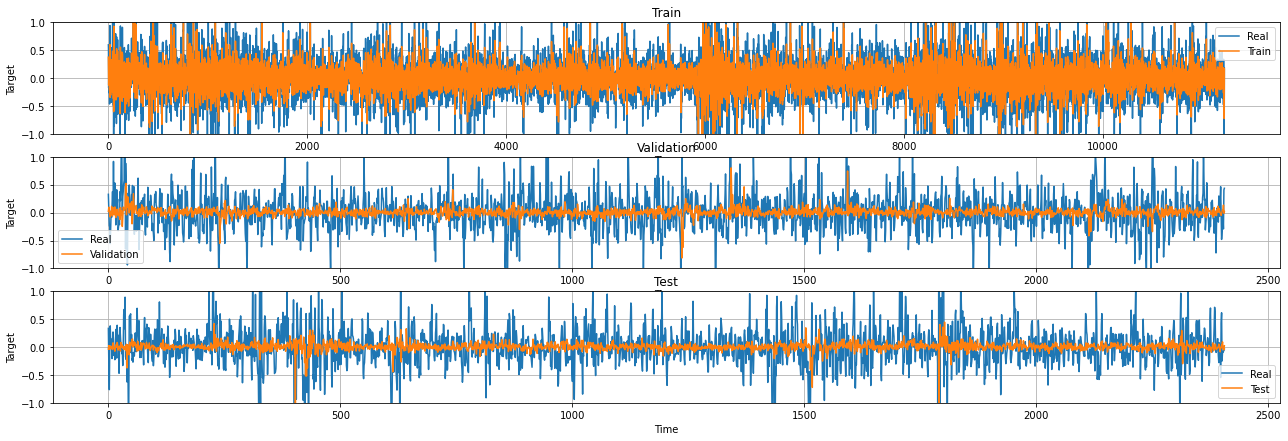

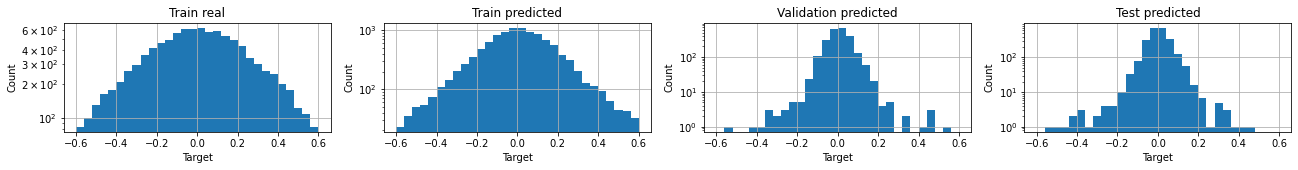

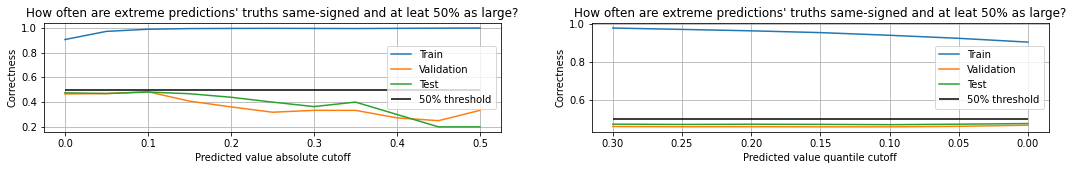

CPU times: user 5min 50s, sys: 1.47 s, total: 5min 52s
Wall time: 59 s


In [36]:
%%time
# basic RF benchmark
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=75, max_samples=0.8, max_features=0.8, n_jobs=-1)
rf.fit(other_train_X, other_train_y)

train_prediction = rf.predict(other_train_X)
validation_prediction = rf.predict(other_validation_X)
test_prediction = rf.predict(other_test_X)

print(mean_squared_error(train_prediction, other_train_y, squared=False))
print(mean_squared_error(validation_prediction, other_validation_y, squared=False))
print(mean_squared_error(test_prediction, other_test_y, squared=False))
visualize_model_predictions(other_train_y, other_validation_y, other_test_y, train_prediction, validation_prediction, test_prediction)

0.31754485
0.36632103
0.38436675


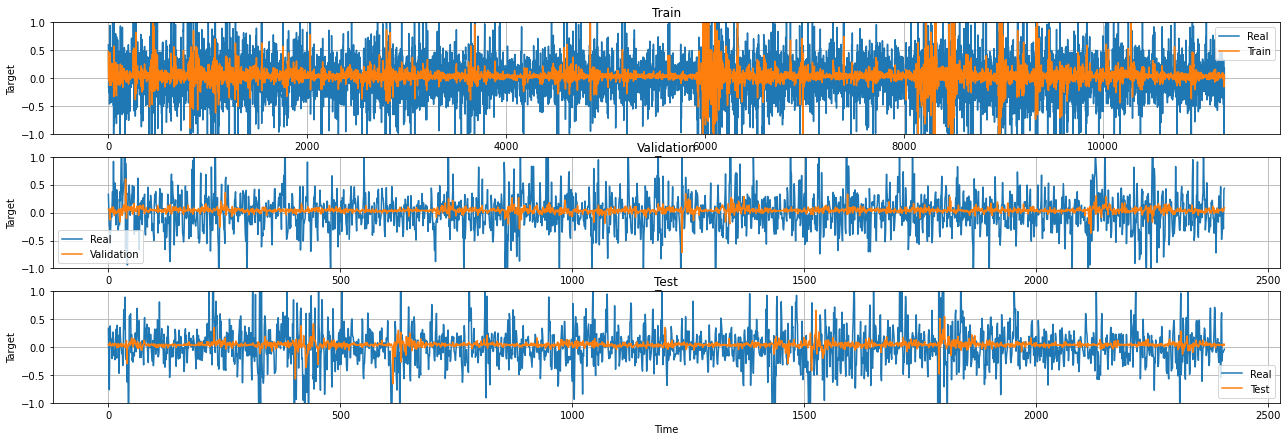

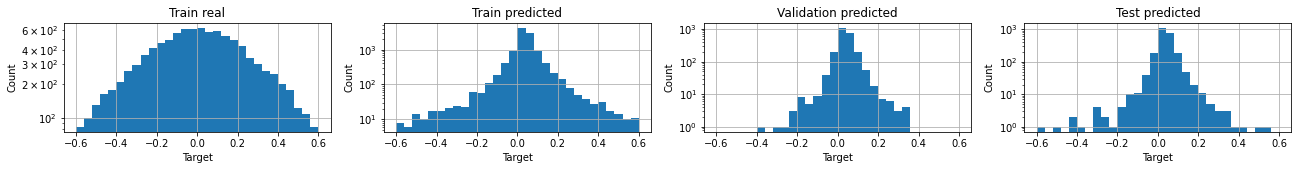

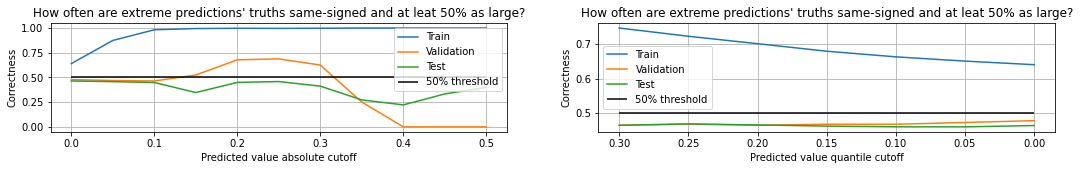

CPU times: user 1min 58s, sys: 620 ms, total: 1min 58s
Wall time: 19.8 s


In [37]:
%%time
# basic XGBoost benchmark
from xgboost import XGBRegressor

xgb = XGBRegressor(objective="reg:squarederror", subsample=0.8, colsample_bytree=0.8, n_estimators=1000, n_jobs=-1, learning_rate=0.05, max_depth=13)
xgb.fit(other_train_X, other_train_y, verbose=False,
        eval_set=[(other_train_X, other_train_y),(other_validation_X, other_validation_y)], early_stopping_rounds=30)

train_prediction = xgb.predict(other_train_X)
validation_prediction = xgb.predict(other_validation_X)
test_prediction = xgb.predict(other_test_X)

print(mean_squared_error(train_prediction, other_train_y, squared=False))
print(mean_squared_error(validation_prediction, other_validation_y, squared=False))
print(mean_squared_error(test_prediction, other_test_y, squared=False))
visualize_model_predictions(other_train_y, other_validation_y, other_test_y, train_prediction, validation_prediction, test_prediction)

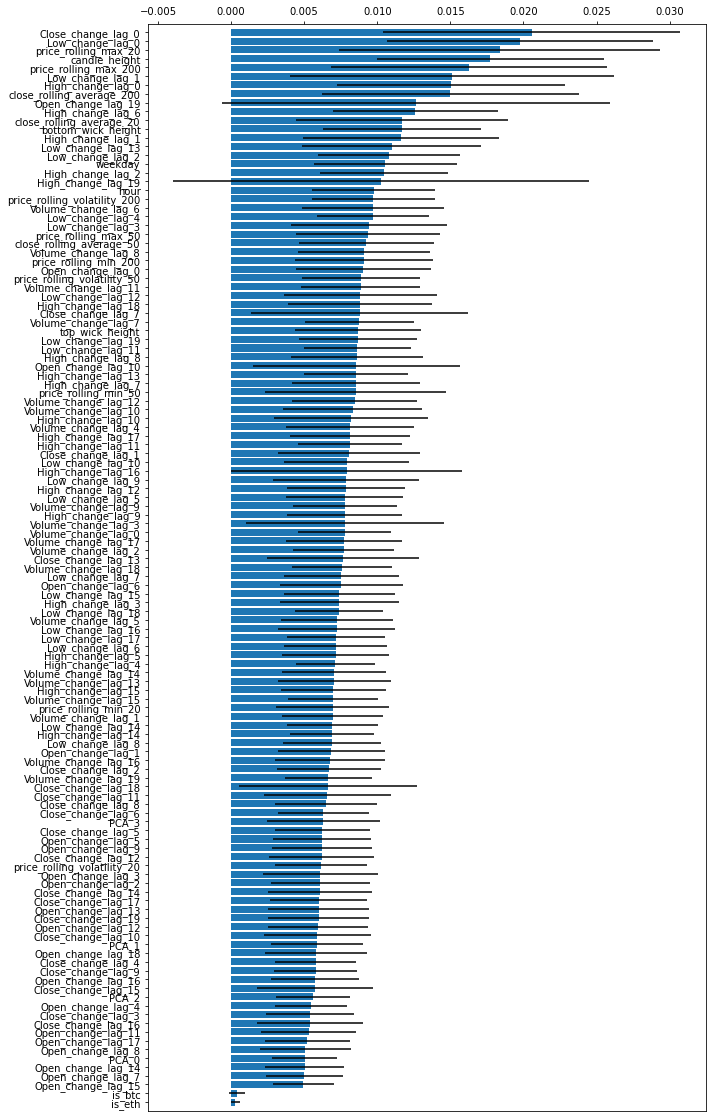

In [38]:
# RF feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)#[::-1]

fig, ax = plt.subplots(figsize=(10, 20))
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
plt.barh(range(other_train_X.shape[1]), importances[indices], xerr=std[indices], align="center")

plt.yticks(range(other_train_X.shape[1]), [other_train_X.columns[ix] for ix in indices], rotation='horizontal')
plt.ylim([-1, other_train_X.shape[1]])
ax.xaxis.tick_top()
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               31744     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 295,169
Trainable params: 295,169
Non-trai

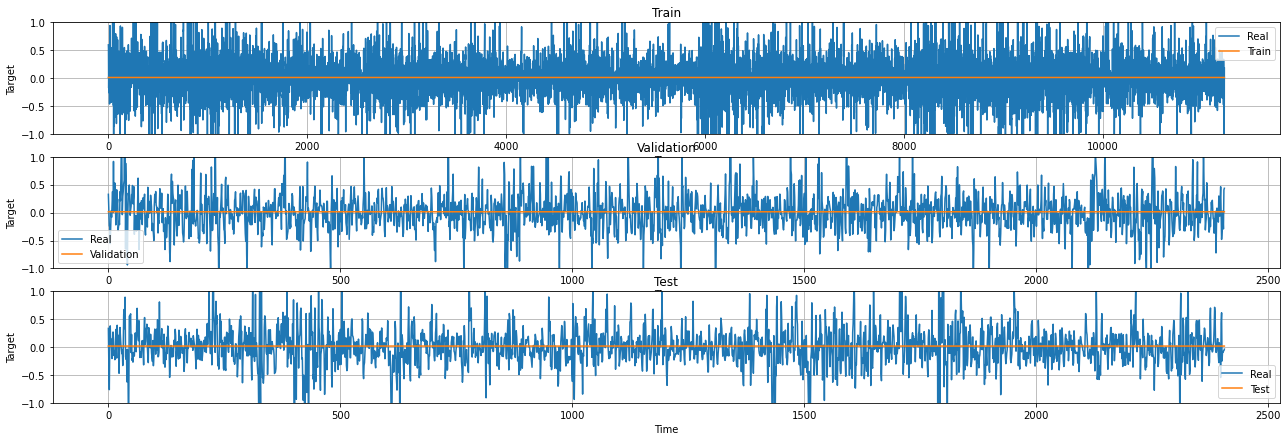

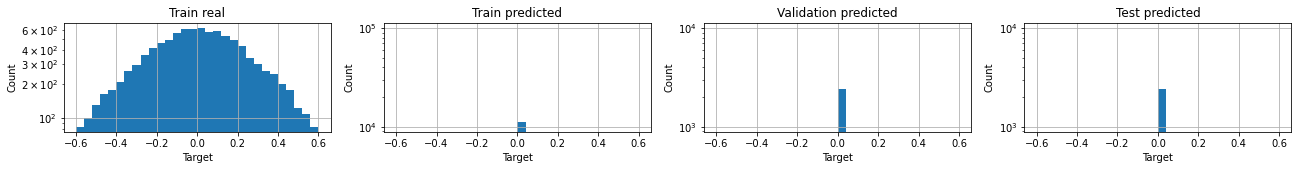

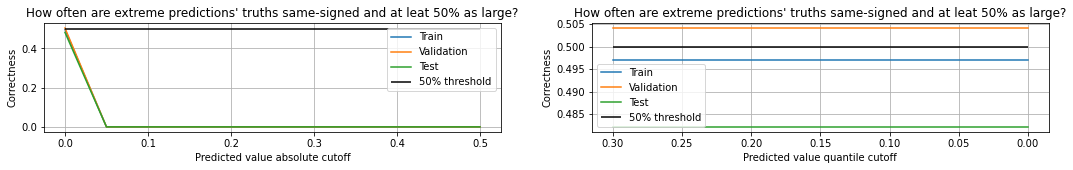

CPU times: user 6min 40s, sys: 30 s, total: 7min 10s
Wall time: 2min 18s


In [39]:
%%time
# basic NN benchmark
from sklearn.metrics import mean_squared_error
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(other_train_X.shape[1],)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
save_best = tf.keras.callbacks.ModelCheckpoint('NN.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

# batch size?
# very many epochs may be needed for breakthroughs
try:
    model.fit(other_train_X, other_train_y,
              batch_size=32,
              verbose=2,
              callbacks=[stop_early, save_best],
              epochs=200,
              shuffle=True,
              validation_data=(other_validation_X, other_validation_y))
except KeyboardInterrupt:
    pass

model = tf.keras.models.load_model('NN.hdf5')

#Calculate predication for training, validation and test data
train_prediction = model.predict(other_train_X).flatten()
validation_prediction = model.predict(other_validation_X).flatten()
test_prediction = model.predict(other_test_X).flatten()

print(mean_squared_error(train_prediction, other_train_y, squared=False))
print(mean_squared_error(validation_prediction, other_validation_y, squared=False))
print(mean_squared_error(test_prediction, other_test_y, squared=False))
visualize_model_predictions(other_train_y, other_validation_y, other_test_y, train_prediction, validation_prediction, test_prediction)

# Complex NN benchmarks

In [40]:
import pickle
rnn_train_X = pickle.load(open('rnn_train_X.pickle', 'rb'))
rnn_train_y = pickle.load(open('rnn_train_y.pickle', 'rb'))
rnn_validation_X = pickle.load(open('rnn_validation_X.pickle', 'rb'))
rnn_validation_y = pickle.load(open('rnn_validation_y.pickle', 'rb'))
rnn_test_X = pickle.load(open('rnn_test_X.pickle', 'rb'))
rnn_test_y = pickle.load(open('rnn_test_y.pickle', 'rb'))
rnn_train_X.shape

(11152, 50, 24)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 24)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 50, 128)      45568       ['input_2[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 50, 128)     98816       ['bidirectional[0][0]']          
 )                                                                                                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 50, 128)     98816       ['bidirectional_1[0][0]']    

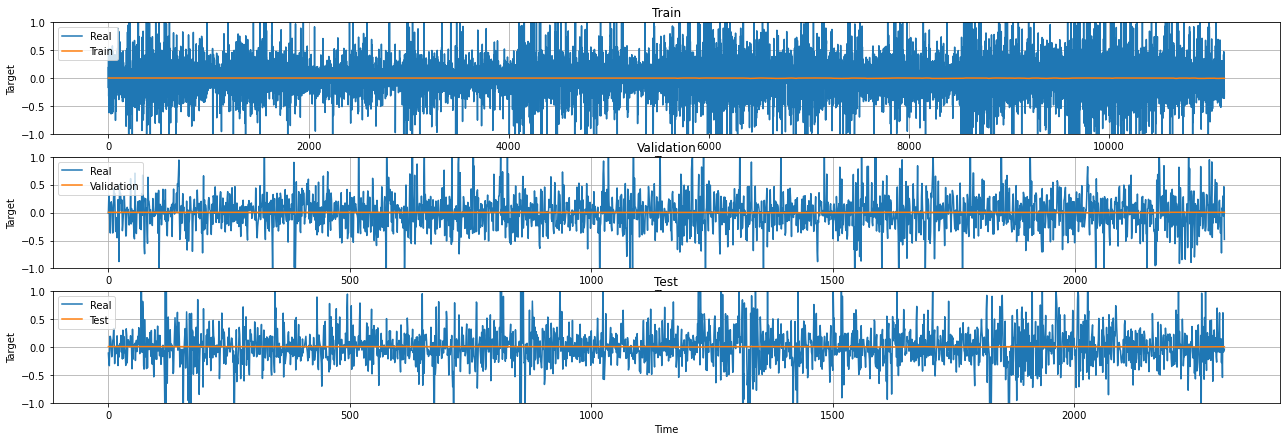

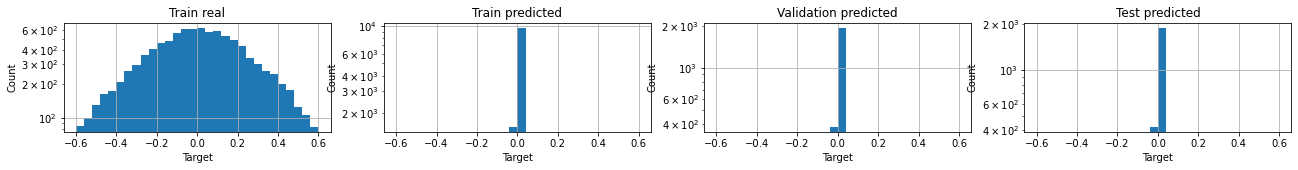

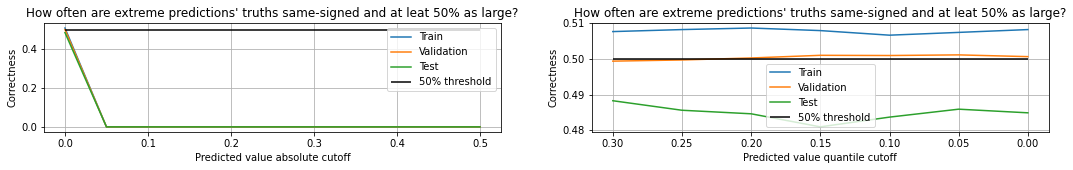

CPU times: user 32min 26s, sys: 3min 2s, total: 35min 29s
Wall time: 6min 36s


In [41]:
%%time
# LSTM benchmark
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

#import warnings
#warnings.filterwarnings('ignore')

# activations between layers?
# dropout instead of dense?
# are poolings needed?
# return_sequences?
in_seq = Input(shape=(rnn_train_X.shape[1], rnn_train_X.shape[2]))
x = Bidirectional(LSTM(64, return_sequences=True))(in_seq)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x) 
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
dense = Dense(128, activation="relu")(conc)
dense = Dense(128, activation="relu")(dense)
dense = Dense(128, activation="relu")(dense)
out = Dense(1)(dense)
model = Model(inputs=in_seq, outputs=out)

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save_best = tf.keras.callbacks.ModelCheckpoint('LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

# batch size?
# very many epochs may be needed for breakthroughs
try:
    model.fit(rnn_train_X, rnn_train_y,
              batch_size=32,
              verbose=2,
              callbacks=[stop_early, save_best],
              epochs=20,
              shuffle=True,
              validation_data=(rnn_validation_X, rnn_validation_y))
except KeyboardInterrupt:
    pass

model = tf.keras.models.load_model('LSTM.hdf5')

#Calculate predication for training, validation and test data
train_prediction = model.predict(rnn_train_X).flatten()
validation_prediction = model.predict(rnn_validation_X).flatten()
test_prediction = model.predict(rnn_test_X).flatten()

print(mean_squared_error(train_prediction, rnn_train_y, squared=False))
print(mean_squared_error(validation_prediction, rnn_validation_y, squared=False))
print(mean_squared_error(test_prediction, rnn_test_y, squared=False))
visualize_model_predictions(rnn_train_y, rnn_validation_y, rnn_test_y, train_prediction, validation_prediction, test_prediction)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 128)           76928     
                                                                 
 batch_normalization (BatchN  (None, 26, 128)          512       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 128)           245888    
                                                                 
 batch_normalization_1 (Batc  (None, 12, 128)          512       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 128)            82048     
                                                                 
 batch_normalization_2 (Batc  (None, 8, 128)          

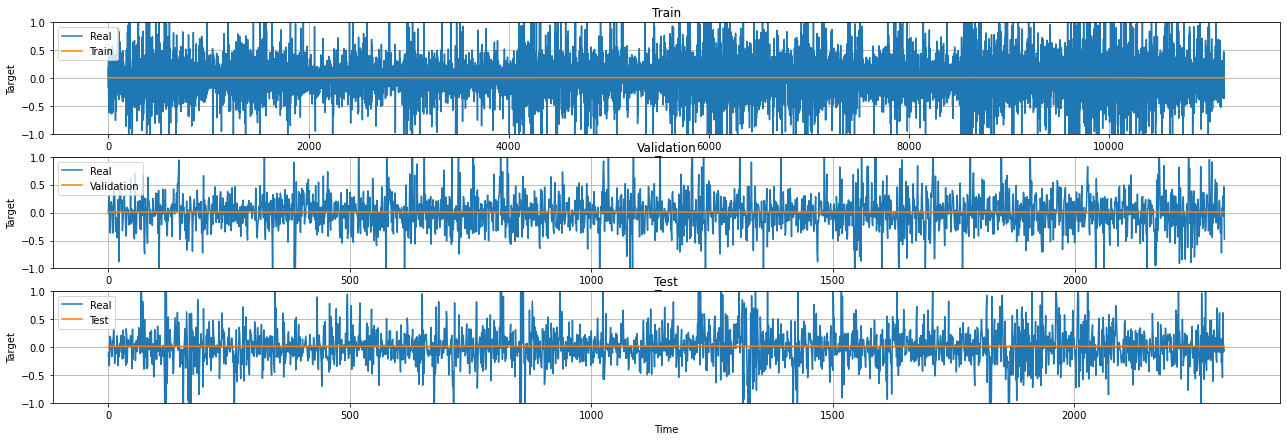

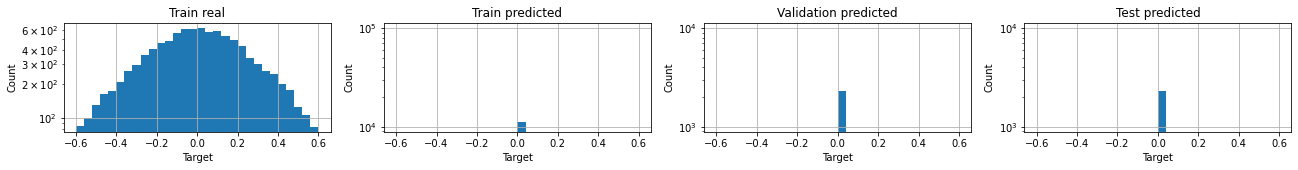

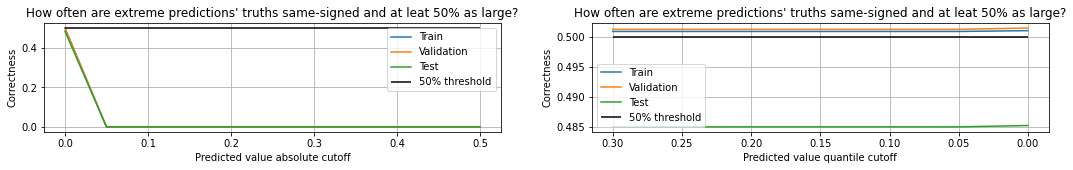

CPU times: user 20min 4s, sys: 42.5 s, total: 20min 47s
Wall time: 4min 22s


In [43]:
%%time
# basic Conv1D benchmark
from sklearn.metrics import mean_squared_error
import tensorflow as tf

conv_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(rnn_train_X.shape[1], rnn_train_X.shape[2])),
    tf.keras.layers.Conv1D(filters=128,
                           kernel_size=(25,),
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=128,
                           kernel_size=(15,),
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=128,
                           kernel_size=(5,),
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=128,
                           kernel_size=(5,),
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

conv_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
conv_model.summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
save_best = tf.keras.callbacks.ModelCheckpoint('CNN.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

# batch size?
# very many epochs may be needed for breakthroughs
try:
    conv_model.fit(rnn_train_X, rnn_train_y,
                   batch_size=32,
                   verbose=2,
                   callbacks=[stop_early, save_best],
                   epochs=50,
                   shuffle=True,
                   validation_data=(rnn_validation_X, rnn_validation_y))
except KeyboardInterrupt:
    pass

conv_model = tf.keras.models.load_model('CNN.hdf5')

#Calculate predication for training, validation and test data
train_prediction = conv_model.predict(rnn_train_X).flatten()
validation_prediction = conv_model.predict(rnn_validation_X).flatten()
test_prediction = conv_model.predict(rnn_test_X).flatten()

print(mean_squared_error(train_prediction, rnn_train_y, squared=False))
print(mean_squared_error(validation_prediction, rnn_validation_y, squared=False))
print(mean_squared_error(test_prediction, rnn_test_y, squared=False))
visualize_model_predictions(rnn_train_y, rnn_validation_y, rnn_test_y, train_prediction, validation_prediction, test_prediction)